# Bike-share Case Study

This is a capstone project for Google Data Analytics course at coursera.org.

## Summary

*Cyclistic* is a bike-share company in Chicago. The director of marketing believes the company’s future success depends on maximizing the number of annual memberships. Therefore, a new task has arisen: to understand how casual riders and annual members use *Cyclistic* bikes differently. From these insights, the company will design a new marketing strategy to convert casual riders into annual members.

### Company’s goal
Design marketing strategies aimed at converting casual riders (who purchase single-ride or full-day passes) into annual members (who purchase annual memberships).

### Business task
Increase company’s profit by converting casual riders into annual members.

Use data for the last 12 months to understand how do annual members and casual riders use *Cyclistic* bikes differently, then design a marketing strategies aimed at converting casual riders into annual members.

## Prepare data

### Data source
I used internal data, collected by the company.
The data contains rides for the past 12 month, from `December 2021` to `November 2022`.
All the data provided in spreadsheets, in .csv files, one file for each month.

[Link to the files](https://divvy-tripdata.s3.amazonaws.com/index.html)

### Licensing, privacy, security, and accessibility
The data has been made available by Motivate International Inc. under [this license](https://ride.divvybikes.com/data-license-agreement).

The data is public and include different customer types, but not personal information. In this analysis we’re not using riders’ personally identifiable information. This means that we won’t be able to connect pass purchases to credit card numbers to determine if casual riders live in the *Cyclistic* service area or if they have purchased multiple single passes.

### Data preparation process in R

First, I installed `tidyverse` package:

In [ ]:
install.packages("tidyverse")
library(tidyverse)

Then created a table `bike_rides_table` with all the data from `December 2021` to `November 2022`:

In [ ]:
bike_rides_table <- list.files(path = "C:/Users/…/Cyclistic Case Study 1/CSV data", pattern = "*.csv") %>% map_df(~read_csv(.))
head(bike_rides_table)

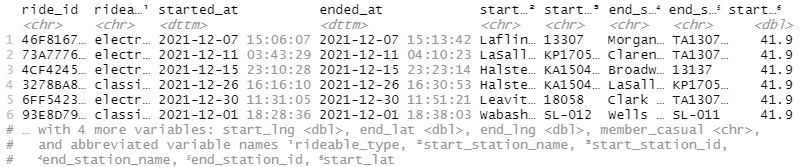

In [ ]:
colnames(bike_rides_table)

 [1] "ride_id"            "rideable_type"      "started_at"         "ended_at"           "start_station_name" "start_station_id"  
 [7] "end_station_name"   "end_station_id"     "start_lat"          "start_lng"          "end_lat"            "end_lng"           
[13] "member_casual"  

Data consists of:
1. ride ID
2. type of the bike, that has three values:

In [ ]:
distinct(bike_rides_table, rideable_type)

- electric_bike
- classic_bike 
- docked_bike  

3. start time of a ride
4. end time of a ride
5. start station name
6. start station ID
7. end station name
8. end station ID
9. start latitude
10. start longitude
11. end latitude
12. end longitude
13. member type, that has two possible values:

In [ ]:
distinct(bike_rides_table, member_casual)

- member
- casual

 Installed `dplyr` package and filtered the data by start time of a ride:

In [ ]:
install.packages("dplyr")
library("dplyr")
bike_rides_table = bike_rides_table %>% arrange(started_at)

## Process data

I use **R** for analysis because there are more than 5 million rows of data, and R is fast and convenient tool when it comes to analyzing big data.

### Cleaning data

#### Step 1: I made sure all the rides are unique

The number of rows in `bike_rides_table` (rides for the last 12 month) is **5 733 451**, which is equal to the number of distinct values of `ride_id`:

In [ ]:
nrow(bike_rides_table)
n_distinct(bike_rides_table$ride_id)

#### Step 2: I added a `ride_length` column and made sure the start time and the end time are correct

In [ ]:
bike_rides_table['ride_length'] <- difftime(bike_rides_table$ended_at, bike_rides_table$started_at, units = "mins")
bike_rides_table %>% filter(ride_length<=0)
view(bike_rides_table %>% filter(ride_length<=0))

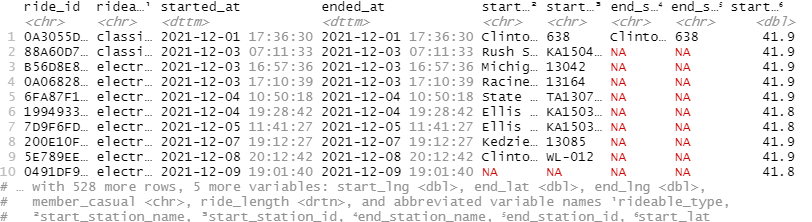

538 rides are either 0 minutes long or have negative length. I filtered them out as errors because I don’t have an opportunity to contact people responsible for the data and ask them to correct this information.

In [ ]:
bike_rides_table <- bike_rides_table %>% filter(ride_length>0)
nrow(bike_rides_table )

As a result, there are 5 732 913 rides left.

There are also rides that last for too long, for more than a day. It's not clear to me whether they’re data errors too or people rent bikes for several days. I left them as they are.

#### Step 3: Made sure there are no undefined values.

In [ ]:
bike_rides_table %>% filter(is.na(start_station_name))

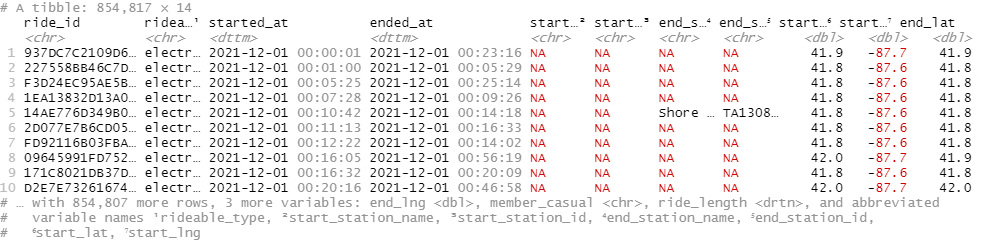

Filtering undefined values in table columns shows that columns `start_station_name`, `start_station_id`, `end_station_name`, `end_station_id`, `end_lat`, `end_lng` has `NA` values. For my current analysis these columns are not critical, so I’m not filtering them out.
Other columns has no `NA` values.

#### Step 4: Added a weekday column

In [ ]:
install.packages("lubridate")
library(lubridate)
bike_rides_table['weekday'] <- wday(bike_rides_table$started_at, week_start=1)
bike_rides_table['weekday_name'] <- wday(bike_rides_table$started_at, label=TRUE, abbr=FALSE, week_start=1)
bike_rides_table['workday_weekend'] <- ifelse(bike_rides_table$weekday < 6, 'workday', 'weekend')

## Analyze data

I calculated mean ride length for casual riders and members:

In [ ]:
bike_rides_table %>% group_by(member_casual) %>% summarize(mean_ride_length = mean(ride_length))

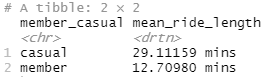

Calculated max ride length for both types:

In [ ]:
bike_rides_table %>% group_by(member_casual) %>% summarize(mean_ride_length = max(ride_length))

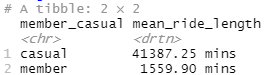

Calculated the mode of day of week:

In [ ]:
getmode <- function(v) {
    uniqv <- unique(v)
    uniqv[which.max(tabulate(match(v, uniqv)))]
}
mode_all <- getmode(bike_rides_table$weekday)
mode_members <- getmode((bike_rides_table %>% filter(member_casual == "member"))$weekday)
mode_casual <- getmode((bike_rides_table %>% filter(member_casual == "casual"))$weekday)

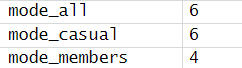

> **So a day with the highest number of occurrences is Saturday for casual users and Thurdsay for members.**

According to **tripadvisor** web-site, Chicago’s rush hours are roughly `6-8 AM` and `4-6 PM`.

Added a new column `rush_hour`:

In [ ]:
bike_rides_table['rush_hour'] <- ifelse(workday_weekend = 'workday' 
                                        & hour(bike_rides_table$started_at) >= 6 
                                        & hour(bike_rides_table$started_at) <= 8, TRUE, 
                                        ifelse(workday_weekend = 'workday' 
                                                & hour(bike_rides_table$started_at) >= 16 
                                                & hour(bike_rides_table$started_at) <= 18, TRUE, FALSE))

For visualizations installed `ggplot2` package:

In [ ]:
install.packages("ggplot2")
library(ggplot2)

I created a bar chart with average ride length:

In [ ]:
mean_ride_length <- bike_rides_table %>% group_by(member_casual) %>% summarize(avg_ride_length_min = mean(ride_length))
mean_ride_length$avg_ride_length_min <- as.numeric(mean_ride_length$avg_ride_length_min)
g_avg <- ggplot(mean_ride_length, aes(member_casual)) + geom_bar(aes(weight = avg_ride_length_min)) 
            + labs(title = "Average ride length", y = "Avg ride length (min)", x = "Customer type")

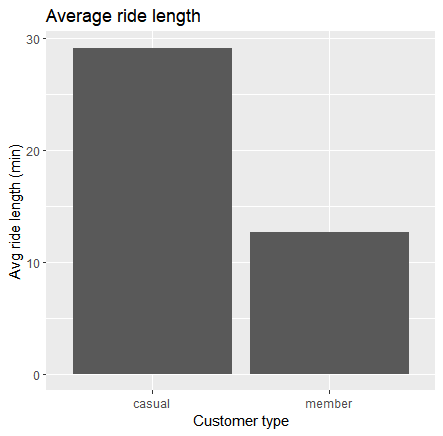

> Average ride for casual users is about 29 min, for members it is around 13 min. It means, that **members typically use bikes for shorter rides while casual users prefer long-distance rides**.

Then I made a chart with average ride length by day of week:

In [ ]:
mean_ride_length_weekdays <- bike_rides_table %>% group_by(member_casual, weekday_name) 
        %>% summarize(avg_ride_length_min = mean(ride_length))

mean_ride_length_weekdays$avg_ride_length_min <- as.numeric(mean_ride_length_weekdays$avg_ride_length_min)

g_avg_weekdays <- ggplot(mean_ride_length_weekdays, aes(weekday_name)) 
        + geom_bar(aes(weight = avg_ride_length_min, fill = weekday_name)) 
        + labs(title = "Average ride length", subtitle = "by day of week", y = "Avg ride length (min)", x = "") 
        + facet_grid(rows = vars(member_casual))
        + theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), legend.title = element_blank())

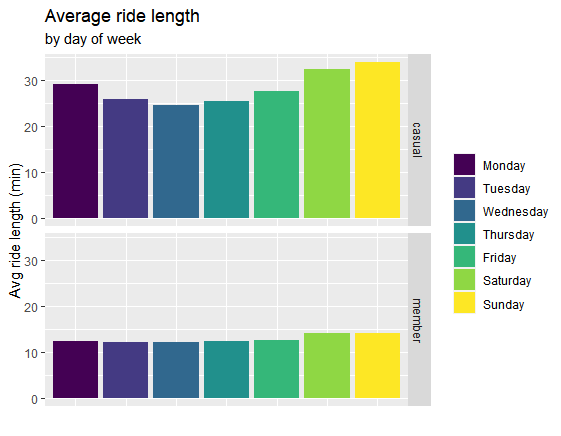

> The chart shows that **casual users tend to have longer rides on Mondays** compared with the rest of the workdays. Members' ride length is the same during the workweek. On weekends both casual users and members have longer average ride length.

Next, I calculated the number of rides for users by day of week:

In [ ]:
count_rides_weekdays <- bike_rides_table %>% group_by(member_casual, weekday_name) 
        %>% summarize(count_rides = n())
    
install.packages("scales")
library(scales)

g_count_rides <- ggplot(count_rides_weekdays, aes(weekday_name)) 
        + geom_bar(aes(weight =count_rides, fill = weekday_name)) 
        + labs(title = "Number of rides", subtitle = "by day of week", y = "Number of rides", x = "") 
        + facet_grid(rows = vars(member_casual))
        + theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), legend.title = element_blank()) 
        + scale_y_continuous(labels = comma)

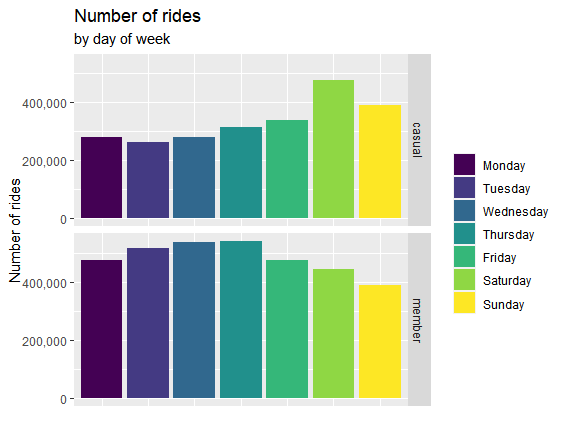

> **Casual users are significantly more active on weekends compared to weekdays.** Members are more active during workdays, especially Wednesdays and Thursdays.

I made a chart to differentiate workdays and weekends:

In [ ]:
mean_ride_length_work_weekend <- bike_rides_table %>% group_by(member_casual, workday_weekend) 
        %>% summarize(avg_ride_length_min = mean(ride_length))

mean_ride_length_work_weekend$avg_ride_length_min <- as.numeric(mean_ride_length_work_weekend$avg_ride_length_min)

g_avg_work_weekend <- ggplot(mean_ride_length_work_weekend, aes(workday_weekend)) 
        + geom_bar(aes(weight = avg_ride_length_min, fill = workday_weekend)) 
        + labs(title = "Average ride length", subtitle = "workdays/weekends", y = "Avg ride length (min)", x = "") 
        + facet_grid(rows = vars(member_casual))
        + theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), legend.title = element_blank())

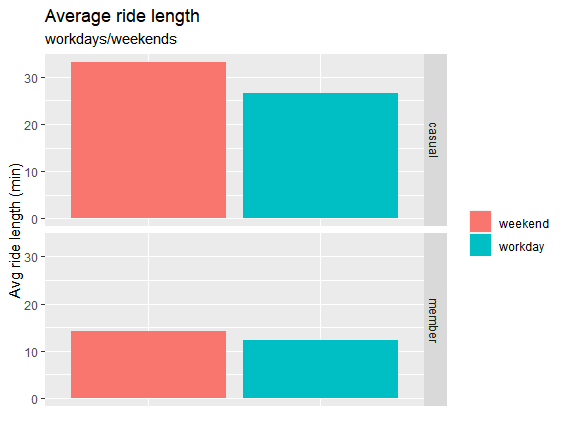

> Here, again, the chart shows that **workday/weekend ride length difference is more pronounced for casual users** compared to members.

Then I made a chart to differentiate rides during rush hour:

In [ ]:
count_ride_length_rush_hour <- bike_rides_table %>% group_by(member_casual, rush_hour) 
        %>% summarize(count_rides = n())

g_count_rush_hour <- ggplot(count_ride_length_rush_hour, aes(rush_hour)) 
        + geom_bar(aes(weight = count_rides, fill = rush_hour)) 
        + labs(title = "Number of rides", subtitle = "during rush hour", y = "Number of rides", x = "") 
        + facet_grid(rows = vars(member_casual))
        + theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), legend.title = element_blank())

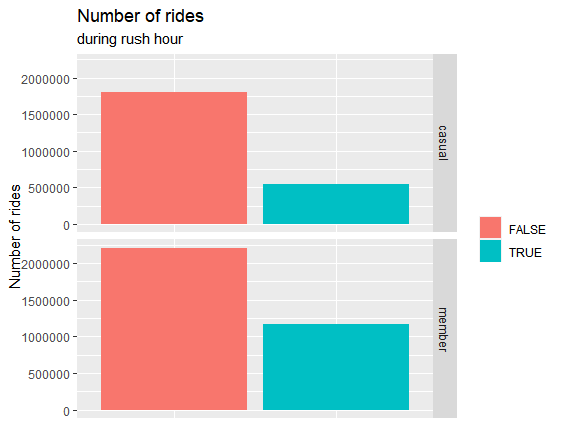

> **During rush hour, casual users ride bikes significantly less than members.**

I split the data by seasons:

In [ ]:
bike_rides_table['season'] <- ifelse(month(bike_rides_table$started_at) >= 3 & month(bike_rides_table$started_at) <= 5, 'spring', 
                                ifelse(month(bike_rides_table$started_at) >= 6 & month(bike_rides_table$started_at) <= 8, 'summer', 
                                ifelse(month(bike_rides_table$started_at) >= 9 & month(bike_rides_table$started_at) <= 11, 'fall', 
                                    'winter')))

Made a chart with average ride length by season:

In [ ]:
mean_ride_length_season <- bike_rides_table %>% group_by(member_casual, season) 
        %>% summarize(avg_ride_length_min = mean(ride_length))

mean_ride_length_season$avg_ride_length_min <- as.numeric(mean_ride_length_season$avg_ride_length_min)

g_avg_season <- ggplot(mean_ride_length_season, aes(season)) 
        + geom_bar(aes(weight = avg_ride_length_min, fill = season)) 
        + labs(title = "Average ride length", subtitle = "by season", y = "Avg ride length (min)", x = "") 
        + facet_grid(rows = vars(member_casual))
        + theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), legend.title = element_blank())

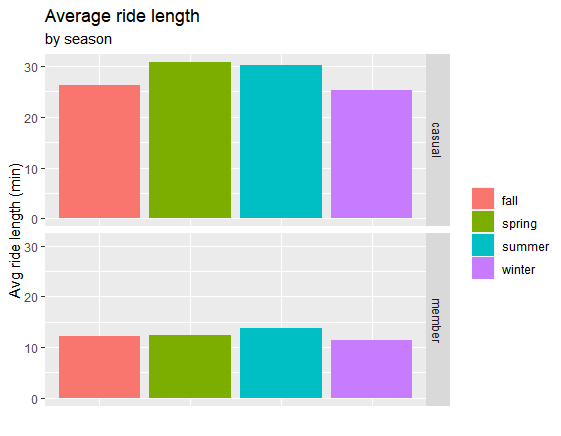

> Both members and casual users tend to have longer rides at summer time, but **casual users' average ride length at spring is even longer**. Members, on the other hand, doesn't have such spike.

I calculated the number of rides for users by season:

In [ ]:
count_rides_season <- bike_rides_table %>% group_by(member_casual, season) 
        %>% summarize(count_rides = n())

g_count_rides_season <- ggplot(count_rides_season, aes(season)) 
        + geom_bar(aes(weight = count_rides, fill = season)) 
        + labs(title = "Number of rides", subtitle = "by season", y = "Number of rides", x = "") 
        + facet_grid(rows = vars(member_casual))
        + theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), legend.title = element_blank())
        + scale_y_continuous(labels = comma)

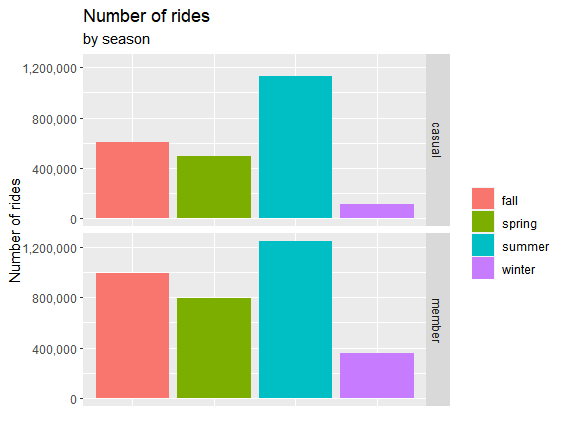

> Winter season's activity is significantly lower compared to other seasons for all riders. The chart shows **more pronounced difference between summer and other seasons for casual users** compared to members. **At summer, number of rides made by casual users doubles** compared to autumn and spring. For members the difference between summer and spring/fall seasons is less significant.

## Conclusion

### Recommendations based on the analysis

1. Casual users are significantly more active during summer season. I suggest creating a marketing campaign and special offers for buying membership during the summer. There is also a significant spike during spring time, and the rides are even longer for casual users, which means that spring is also a good time to start marketing.
2. Winter is a low season, and some bike riders may be reluctant to buy annual membership because they don't use bikes whole year round. I suggest addressing this concern and considering creating seasonal membership for summer and/or summer+spring+fall.
3. Stress longer rides (~30 minutes) benefits: why buying membership is more beneficial for longer rides than renting bikes casually.

### Suggestions for further analysis work

In order to create better marketing campaign could be beneficial to collect more information on riders, such as:
- age group
- gender
- occupation: office worker / blue-collar worker / student / retired
- residence: local / tourist
- a reason for renting a bike: to commute to work / sport / sightseeing and so on

It may be profitable to create:
- special packages for tourists
- special membership offers for students (and advertise them near universities)
- special membership offers for retired people
- based on age group and gender, attract influencers to participate in marketing campaigns
